## Корреляционный анализ

В отчете используются данные об изменений цен акций компаний из индекса S&P 500 на протяжении 5 лет: с февраля 2013 по фераль 2018. Данные можно скачать отсюда: https://www.kaggle.com/camnugent/sandp500.

Импортируем необходимые библиотеки:

** numpy ** - для работы с массивами данных

** pandas ** - для работы с данными, представленными в табличном виде

** matplotlib и seaborn** - для визуализации данных

** модуль stats библиотеки scipy** - непосредственно для статистического анализа

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize']=[10,7]
import seaborn as sns
sns.set()
import scipy.stats as st

Методы .pdf и .cdf позволяют получить для интерсующей статистики значение функции плотности вероятности или функции распределения. В данном случае мы рассматриваем t-распределение.

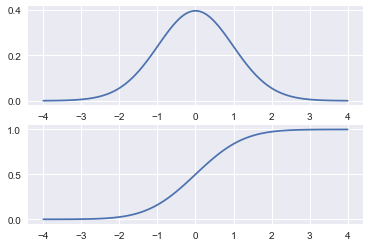

In [15]:
x=np.linspace(-4, 4, 100)
y=st.t.pdf(x, df=50-2)
y_c=st.t.cdf(x, df=50-2)
f, (ax1, ax2)=plt.subplots(2, 1)
ax1.plot(x, y)
ax2.plot(x, y_c)

Считываем данные и конвертируем индексы из текстового формата в формат datetime, предназначенный для работы с временными данными.

In [2]:
sp500=pd.read_csv('data/sandp500/all_stocks_5yr.csv', index_col='date')
sp500.index=sp500.index.to_datetime()

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)
  


Посмотрим, как выглядят данные. Отельный ряд содержит информацию о ценах открытия и закрытия, наивысшую и наименьшую цены акций, а также капитализацию компании в определенный день.

In [53]:
sp500.head()

,open,high,low,close,volume,Name
2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


Создадим список интересующих нас компаний, я выбрал Apple, Microsoft, Amazon, Coca-Cola, Pepsi и General Motors.

In [3]:
companies=['AAPL', 'MSFT', 'AMZN', 'KO', 'PEP', 'GM']

Небольшой скрипт для преобразования таблицы.

In [4]:
filtered=sp500[sp500['Name'].isin(companies)]

from collections import defaultdict
dates=defaultdict(list)
for i in filtered.iterrows():
    dates[i[0]].append(i[1]['close'])
time_series=pd.DataFrame(dates)

In [6]:
time_series.index=sorted(companies)
time_series=time_series.transpose()

Так выглядят данные теперь, каждый ряд соответсвует определенному дню, колонки компаниям. На пересечении колонки и ряда находится цена на закрытии торгов.

In [52]:
time_series.head()

,AAPL,AMZN,GM,KO,MSFT,PEP
2013-02-08,67.8542,261.95,28.57,38.77,27.55,72.60
2013-02-11,68.5614,257.21,28.53,38.61,27.86,72.36
2013-02-12,66.8428,258.70,28.55,37.56,27.88,72.17
2013-02-13,66.7156,269.47,28.67,37.21,28.03,71.50
2013-02-14,66.6556,269.24,27.75,36.84,28.04,72.28


Метод объекта DataFrame .corr позволяет получиться корреляционную матрицу. Как и ожидалось, цены на акции IT-компаний сильно коррелируют друг с другом, также как и акции Кока-Кола и Пепси, когда как General Motors имеет самые низкие коэффициенты корреляции с остальными:

In [8]:
time_series.corr()

,AAPL,AMZN,GM,KO,MSFT,PEP
AAPL,1.000000,0.819078,0.451701,0.661642,0.899689,0.892922
AMZN,0.819078,1.000000,0.376996,0.723407,0.955977,0.906256
GM,0.451701,0.376996,1.000000,0.190191,0.440992,0.251746
KO,0.661642,0.723407,0.190191,1.000000,0.775392,0.823330
MSFT,0.899689,0.955977,0.440992,0.775392,1.000000,0.936613
PEP,0.892922,0.906256,0.251746,0.823330,0.936613,1.000000


Функция подсчета t-статистики для подсчитанных коэффициентов корреляции.

In [9]:
def get_t_values(corr_mat, n):
    rs=corr_mat
    t_values=rs/np.sqrt(1-rs**2)*np.sqrt(n-2)
    return t_values

In [10]:
n=len(time_series)
ts=get_t_values(time_series.corr(), n)
ts

,AAPL,AMZN,GM,KO,MSFT,PEP
AAPL,inf,50.620008,17.950297,31.284832,73.071096,70.317568
AMZN,50.620008,inf,14.430853,37.148064,115.503393,76.007324
GM,17.950297,14.430853,inf,6.868433,17.420435,9.222461
KO,31.284832,37.148064,6.868433,inf,43.534056,51.431340
MSFT,73.071096,115.503393,17.420435,43.534056,inf,94.777491
PEP,70.317568,76.007324,9.222461,51.431340,94.777491,inf


p-values для полученных статистик.

In [49]:
ps=st.t.cdf(abs(ts), df=n-2)-st.t.cdf(-1*abs(ts), df=n-2)
pd.DataFrame(1-ps, index=ts.index, columns=ts.columns)

,AAPL,AMZN,GM,KO,MSFT,PEP
AAPL,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00
AMZN,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00
GM,0.0,0.0,0.000000e+00,5.998286e-10,0.0,5.884182e-15
KO,0.0,0.0,5.998286e-10,0.000000e+00,0.0,0.000000e+00
MSFT,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00
PEP,0.0,0.0,5.884182e-15,0.000000e+00,0.0,0.000000e+00


## Рассмотрим корреляции на меньшем окне

На очень большом временном окне все корреляции оказались статистически значимыми. Нулевая гипотеза о равнестве коэффициента корреляции нулю была отвергнута. Рассмотрим, как ведут себя статистики на меньшем окне, 100 дней:

In [19]:
ts_window_100d=time_series.iloc[-100:,:]
n=len(ts_window_100d)

In [21]:
ts_window_100d.corr()

,AAPL,AMZN,GM,KO,MSFT,PEP
AAPL,1.000000,0.646157,0.096779,0.354672,0.751706,0.650498
AMZN,0.646157,1.000000,-0.000487,0.442234,0.963292,0.746837
GM,0.096779,-0.000487,1.000000,0.265261,0.083227,-0.118167
KO,0.354672,0.442234,0.265261,1.000000,0.514302,0.508349
MSFT,0.751706,0.963292,0.083227,0.514302,1.000000,0.743606
PEP,0.650498,0.746837,-0.118167,0.508349,0.743606,1.000000


In [24]:
ts_100d=get_t_values(ts_window_100d.corr(), n)
ts_100d

,AAPL,AMZN,GM,KO,MSFT,PEP
AAPL,inf,8.381266,0.962581,3.755196,11.283604,8.478638
AMZN,8.381266,inf,-0.004816,4.881143,35.522238,11.117642
GM,0.962581,-0.004816,inf,2.723520,0.826778,-1.178051
KO,3.755196,4.881143,2.723520,inf,5.936661,5.843809
MSFT,11.283604,35.522238,0.826778,5.936661,inf,11.009772
PEP,8.478638,11.117642,-1.178051,5.843809,11.009772,inf


p-values, при уровне значимости 0.05 корреляции оказались значимыми для всех пар, кроме как для GM-AAPL, GM-AMZN, GM-MSFT, GM-PEP.

In [103]:
p100=pd.DataFrame(1-(st.t.cdf(abs(ts_100d), df=n-2)-st.t.cdf(-1*abs(ts_100d), df=n-2)), index=ts_100d.index, columns=ts_100d.columns)
p100

,AAPL,AMZN,GM,KO,MSFT,PEP
AAPL,0.000000e+00,3.871348e-13,0.338127,2.939503e-04,0.000000e+00,2.390310e-13
AMZN,3.871348e-13,0.000000e+00,0.996167,4.093706e-06,0.000000e+00,0.000000e+00
GM,3.381272e-01,9.961669e-01,0.000000,7.648064e-03,4.103714e-01,2.416291e-01
KO,2.939503e-04,4.093706e-06,0.007648,0.000000e+00,4.415746e-08,6.685540e-08
MSFT,0.000000e+00,0.000000e+00,0.410371,4.415746e-08,0.000000e+00,0.000000e+00
PEP,2.390310e-13,0.000000e+00,0.241629,6.685540e-08,0.000000e+00,0.000000e+00


Также для распределения из модуля scipy.stats существует метод .ppf, позволяющий получить критические значения статистик. В данном анализе он не используется, приведен для демонстрации.

In [31]:
print(st.t.ppf(0.975,df=n-2))
print(st.t.ppf(0.025,df=n-2))

1.984467454426692
-1.9844674544266925


In [61]:
def normalize(ts):
    t_mean=ts.mean()
    t_std=ts.std(ddof=1)
    norm_ts=(ts-t_mean)/t_std
    return norm_ts

def min_max_scale(ts):
    t_max=np.max(ts)
    t_min=np.min(ts)
    scaled=(ts-t_min)/(t_max-t_min)
    return scaled

Построим график двух наиболее коррелирующих случайных величин: цен на акции Microsoft и Amazon.

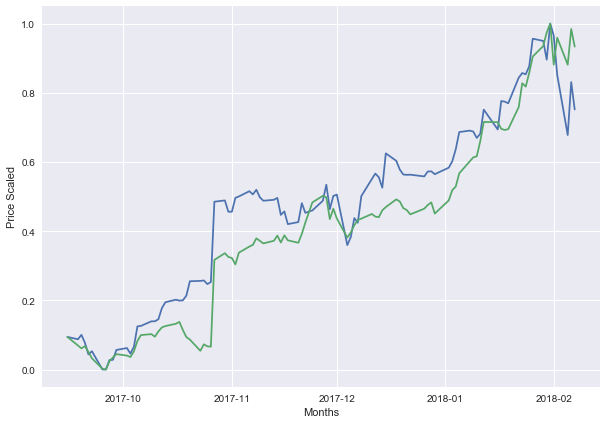

In [64]:
plt.plot(min_max_scale(ts_window_100d['MSFT']))
plt.plot(min_max_scale(ts_window_100d['AMZN']))
_=plt.xlabel('Months')
_=plt.ylabel('Price Scaled')

Попробуем отрисовать цветную таблицу, где зеленым будут обозначенный значимые коэффициенты:

In [70]:
alpha=0.05
colors = p100.applymap(lambda x: 'green' if x<= alpha else 'red').reset_index().drop(['index'], axis=1)

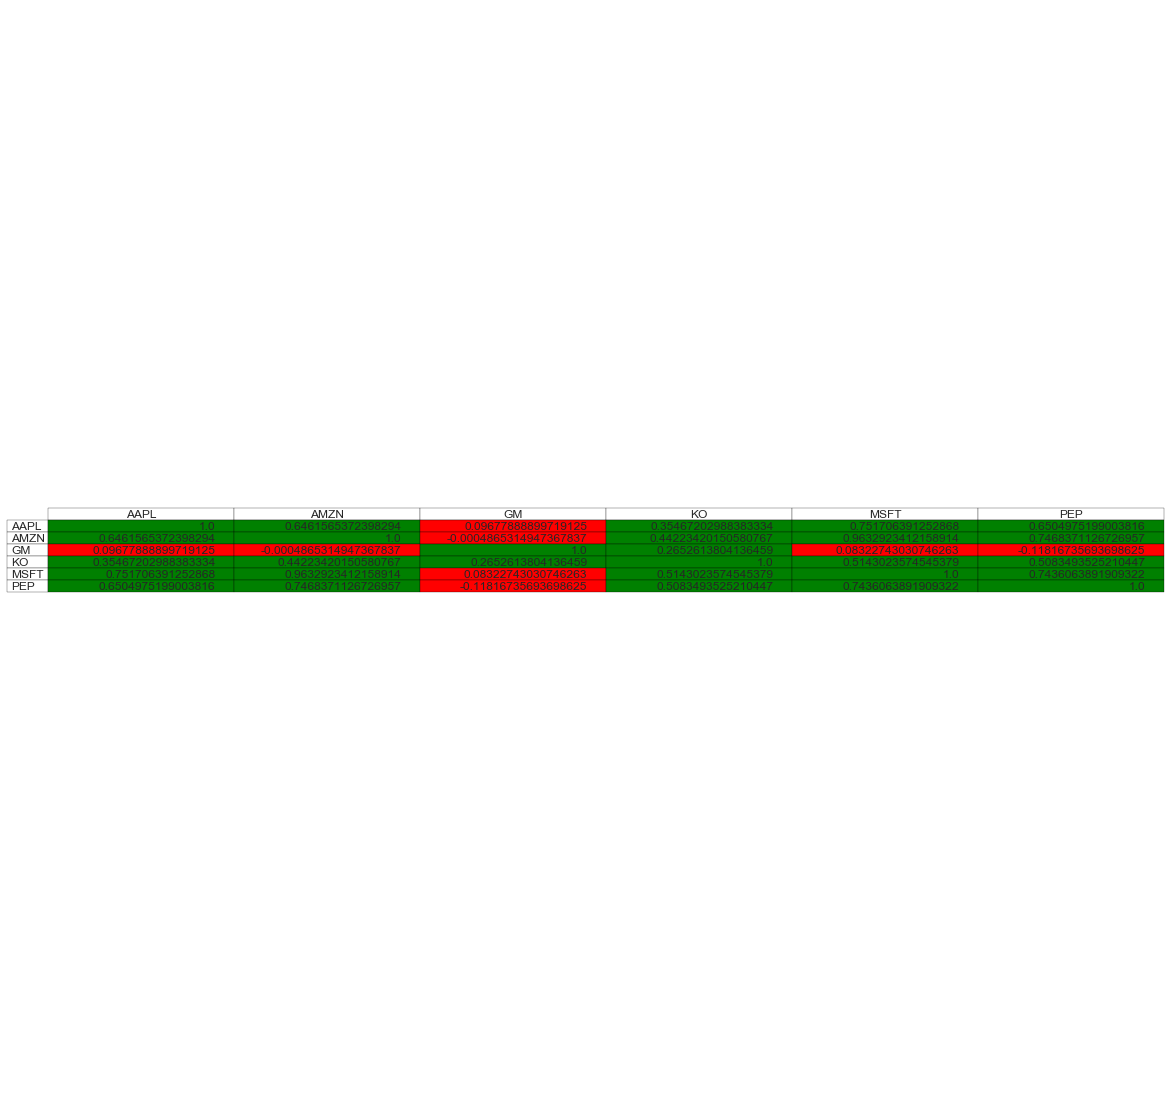

In [102]:
from pandas.plotting import table
plt.figure(figsize=[20, 20]) 
ax = plt.subplot(111, frame_on=False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
table(ax, ts_window_100d.corr(), rowLabels=ts_window_100d.corr().index, colLabels=ts_window_100d.corr().columns, 
      loc='center', cellColours=colors.values)